In [102]:
import torch
import torchvision
import torchvision.transforms as transforms
torch.multiprocessing.set_sharing_strategy('file_system')

In [103]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        embedding = F.relu(self.fc2(x))
        # embedding = x.clone()
        x = self.fc3(embedding)
        return x, embedding

    # def embedding(self, x):
    #     x = self.pool(F.relu(self.conv1(x)))
    #     x = self.pool(F.relu(self.conv2(x)))
    #     x = torch.flatten(x, 1)
    #     x = F.relu(self.fc1(x))
    #     x = F.relu(self.fc2(x))
    #     return x

net_state_dict = torch.load("cifar_trained.pth")
net = Net()
net.load_state_dict(net_state_dict)
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [221]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='/workspace/CHAHAK/dsml/project/data/cifar-10-batches-py', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/workspace/CHAHAK/dsml/project/data/cifar-10-batches-py', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [105]:

embeddings, all_labels = [], []
for i, data in (enumerate(testloader, 0)):
    inputs, labels = data
    _, emb = net(inputs)
    embeddings.append(emb.detach().numpy())
    all_labels.extend(labels)

In [106]:
import numpy as np

embedding_array = np.vstack(embeddings)
embedding_array.shape

(10000, 84)

# K-means clustering

In [107]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import homogeneity_score

kmeans = KMeans(n_clusters=10)
estimator = make_pipeline(StandardScaler(), kmeans).fit(embedding_array)
homogeneity_score(all_labels, estimator[-1].labels_)

0.32385729611117214

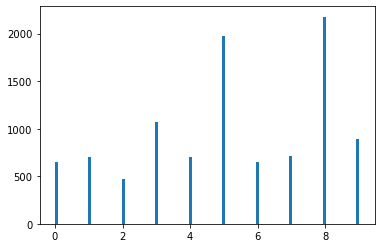

In [108]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
_ = ax.hist(estimator[-1].labels_, bins=100)

# DBSCAN Clean-1 (hyperparameters not set)

In [222]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [223]:
d=euclidean_distances(embedding_array, embedding_array)
d

array([[ 0.       , 10.324991 ,  6.8204637, ...,  3.9978726,  6.765473 ,
         7.9468017],
       [10.324991 ,  0.       ,  6.433682 , ..., 10.65164  ,  8.876804 ,
        12.197256 ],
       [ 6.8204637,  6.433682 ,  0.       , ...,  7.167403 ,  7.9550276,
         9.686363 ],
       ...,
       [ 3.9978726, 10.65164  ,  7.167403 , ...,  0.       ,  8.084082 ,
         8.191697 ],
       [ 6.765473 ,  8.876804 ,  7.9550276, ...,  8.084082 ,  0.       ,
         9.60235  ],
       [ 7.9468017, 12.197256 ,  9.686363 , ...,  8.191697 ,  9.60235  ,
         0.       ]], dtype=float32)

## Plotting distances for different values of epsilon.

Goal is to get approx 1000 per label number on the graph.


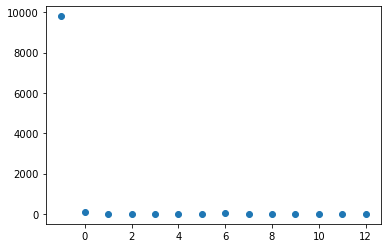

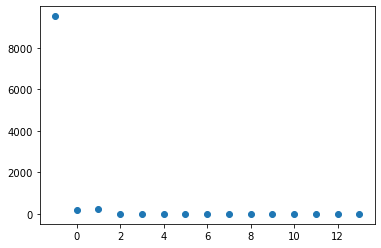

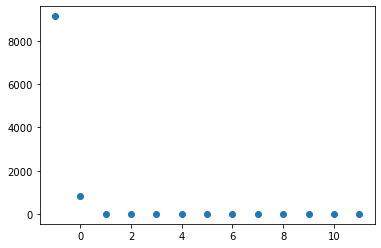

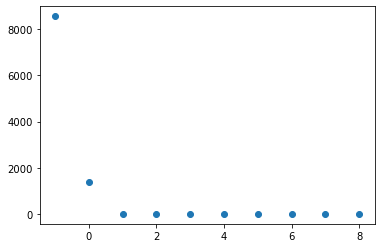

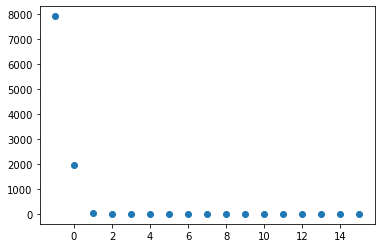

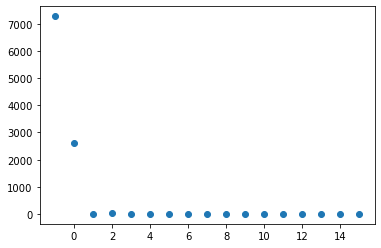

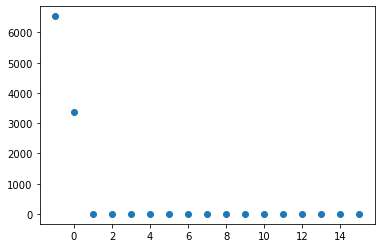

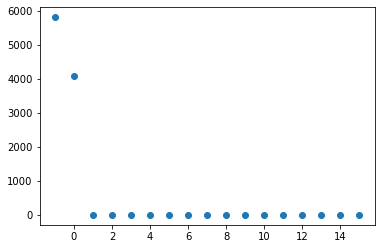

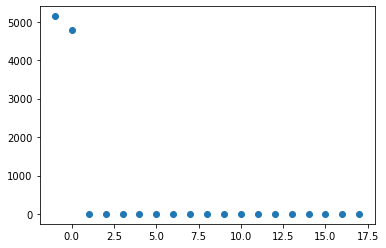

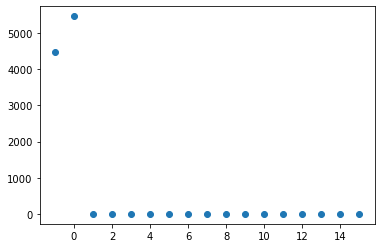

In [231]:
xx=np.linspace(1.2,2,num=10)

count=0
for i in xx:

    db = DBSCAN(eps=i, min_samples=5).fit(embedding_array)
    unique, counts = np.unique(db.labels_, return_counts=True)
    plt.figure(count)
    plt.scatter(unique,counts)
    count=count+1
    

In [232]:
xx

array([1.2       , 1.28888889, 1.37777778, 1.46666667, 1.55555556,
       1.64444444, 1.73333333, 1.82222222, 1.91111111, 2.        ])

### For example, if we take eps=1.35 and min_samples=5, we get:

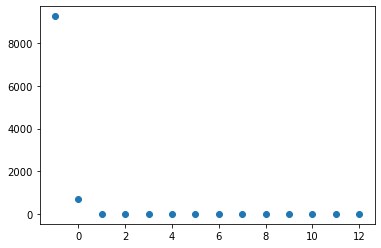

In [233]:
db = DBSCAN(eps=1.35, min_samples=5).fit(embedding_array)
unique, counts = np.unique(db.labels_, return_counts=True)
plt.scatter(unique,counts)

### This is good since we are at least getting ~10 classes, but almost all imgs are unclustered. so this is terrible.

In [236]:
res=np.column_stack((unique,counts))

In [237]:
res

array([[  -1, 9256],
       [   0,  679],
       [   1,    4],
       [   2,    7],
       [   3,    8],
       [   4,    3],
       [   5,    4],
       [   6,    6],
       [   7,    6],
       [   8,    5],
       [   9,    6],
       [  10,    6],
       [  11,    4],
       [  12,    6]], dtype=int64)

# DBSCAN roughwork
(Ignore, for self reference. Will remove soon.)

In [109]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [110]:
embedding_array

array([[0.4635283 , 0.04606063, 0.        , ..., 0.4569245 , 0.        ,
        0.50410897],
       [0.        , 2.1750524 , 0.        , ..., 0.        , 0.        ,
        0.4296655 ],
       [0.        , 1.063138  , 0.        , ..., 0.45108694, 0.        ,
        0.16996802],
       ...,
       [0.        , 0.03085645, 0.        , ..., 0.2746104 , 0.        ,
        0.22153799],
       [0.        , 0.        , 0.        , ..., 0.34808582, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [111]:
d=euclidean_distances(embedding_array, embedding_array)
d

array([[ 0.       , 10.324991 ,  6.8204637, ...,  3.9978726,  6.765473 ,
         7.9468017],
       [10.324991 ,  0.       ,  6.433682 , ..., 10.65164  ,  8.876804 ,
        12.197256 ],
       [ 6.8204637,  6.433682 ,  0.       , ...,  7.167403 ,  7.9550276,
         9.686363 ],
       ...,
       [ 3.9978726, 10.65164  ,  7.167403 , ...,  0.       ,  8.084082 ,
         8.191697 ],
       [ 6.765473 ,  8.876804 ,  7.9550276, ...,  8.084082 ,  0.       ,
         9.60235  ],
       [ 7.9468017, 12.197256 ,  9.686363 , ...,  8.191697 ,  9.60235  ,
         0.       ]], dtype=float32)

In [112]:
d[0].sum()/d[0].shape

array([5.50703242])

In [113]:
d.shape

(10000, 10000)

In [201]:
db = DBSCAN(eps=2, min_samples=10).fit(embedding_array)

In [202]:
l=db.labels_
print(set(l))


{0, 1, 2, -1}


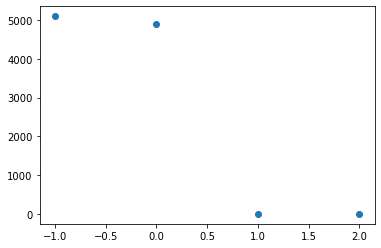

In [203]:
unique, counts = np.unique(l, return_counts=True)
plt.scatter(unique,counts)

In [216]:
xx.shape

(10,)

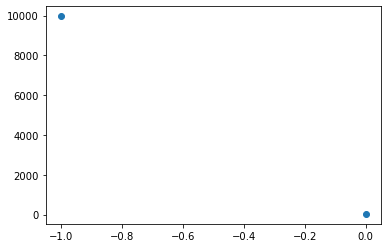

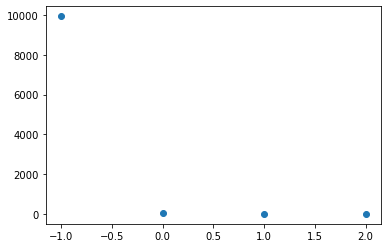

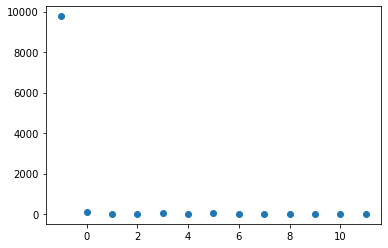

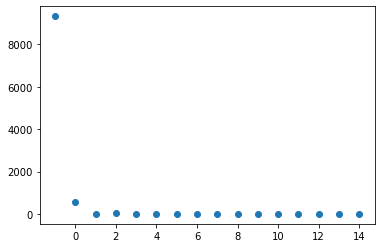

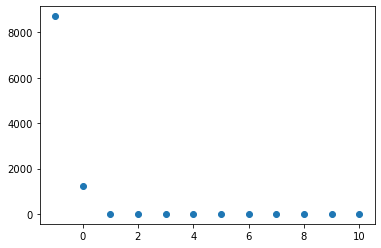

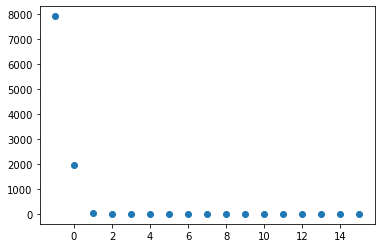

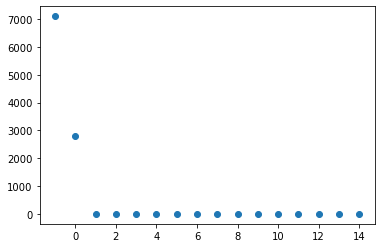

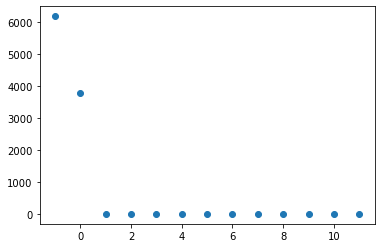

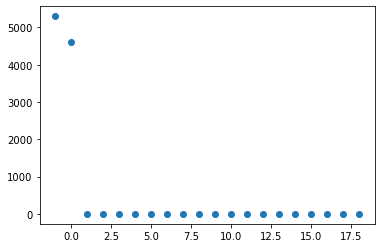

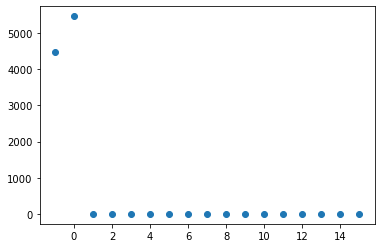

In [219]:
xx=np.linspace(1,2,num=10)

count=0
for i in xx:

    db = DBSCAN(eps=i, min_samples=5).fit(embedding_array)
    unique, counts = np.unique(db.labels_, return_counts=True)
    plt.figure(count)
    plt.scatter(unique,counts)
    count=count+1
    

In [121]:
g=torch.tensor(all_labels)

In [131]:
arr_labls=g.numpy()

In [43]:
embedding_array.shape

(10000, 84)